In [11]:
import sys
import os
from math import log
import numpy as np
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt
# import cv2
import pandas as pd

# root_path = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/"
# path_pesi_old = "/content/drive/MyDrive/progetto_SS/checkpoints_test_combined_5_test/pesi/pesi.h5"
save_checkpoints_path = "../model_checkpoints"
# path_root = "/content/drive/MyDrive/progetto_SS/malimg_paper_dataset_imgs"

# class_index = {'Adialer.C': 0,
#                'Agent.FYI': 1,
#                'Allaple.A': 2,
#                'Allaple.L': 3,
#                'Alueron.gen!J': 4,
#                'Autorun.K': 5,
#                'Benign': 6,
#                'C2LOP.P': 7,
#                'C2LOP.gen!g': 8,
#                'Dialplatform.B': 9,
#                'Dontovo.A': 10,
#                'Fakerean': 11,
#                'Instantaccess': 12,
#                'Lolyda.AA1': 13,
#                'Lolyda.AA2': 14,
#                'Lolyda.AA3': 15,
#                'Lolyda.AT': 16,
#                'Malex.gen!J': 17,
#                'Obfuscator.AD': 18,
#                'Rbot!gen': 19,
#                'Skintrim.N': 20,
#                'Swizzor.gen!E': 21,
#                'Swizzor.gen!I': 22,
#                'VB.AT': 23,
#                'Wintrim.BX': 24,
#                'Yuner.A': 25}

# only malimg data set 
train_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\train_malimg.csv")
test_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\test_malimg.csv")
val_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\val_malimg.csv")

# dataset with benign images
train_combined_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\train_combined_malimg.csv")
test_combined_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\test_combined_malimg.csv")
val_combined_df = pd.read_csv("C:\\Users\\youssef khaled\\Desktop\\GP\\dataSets\\CSVs\\val_combined_malimg.csv")

train_df = train_combined_df
test_df = test_combined_df
val_df = val_combined_df

In [12]:
from keras.preprocessing.image import ImageDataGenerator
batch_size = 16
target_size_custom = (256, 256)

datagen = ImageDataGenerator(
    rescale=1 / 255.0)

# image data prepration for AI model malimage only 
train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=None,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    # color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)

test_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=None,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    # color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
    seed=42
)
val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=None,
    x_col="img_code",
    y_col="target",
    target_size=target_size_custom,
    # color_mode = "grayscale",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=42
)


class_index = train_gen.class_indices

Found 8324 validated image filenames belonging to 26 classes.
Found 1066 validated image filenames belonging to 26 classes.
Found 1031 validated image filenames belonging to 26 classes.


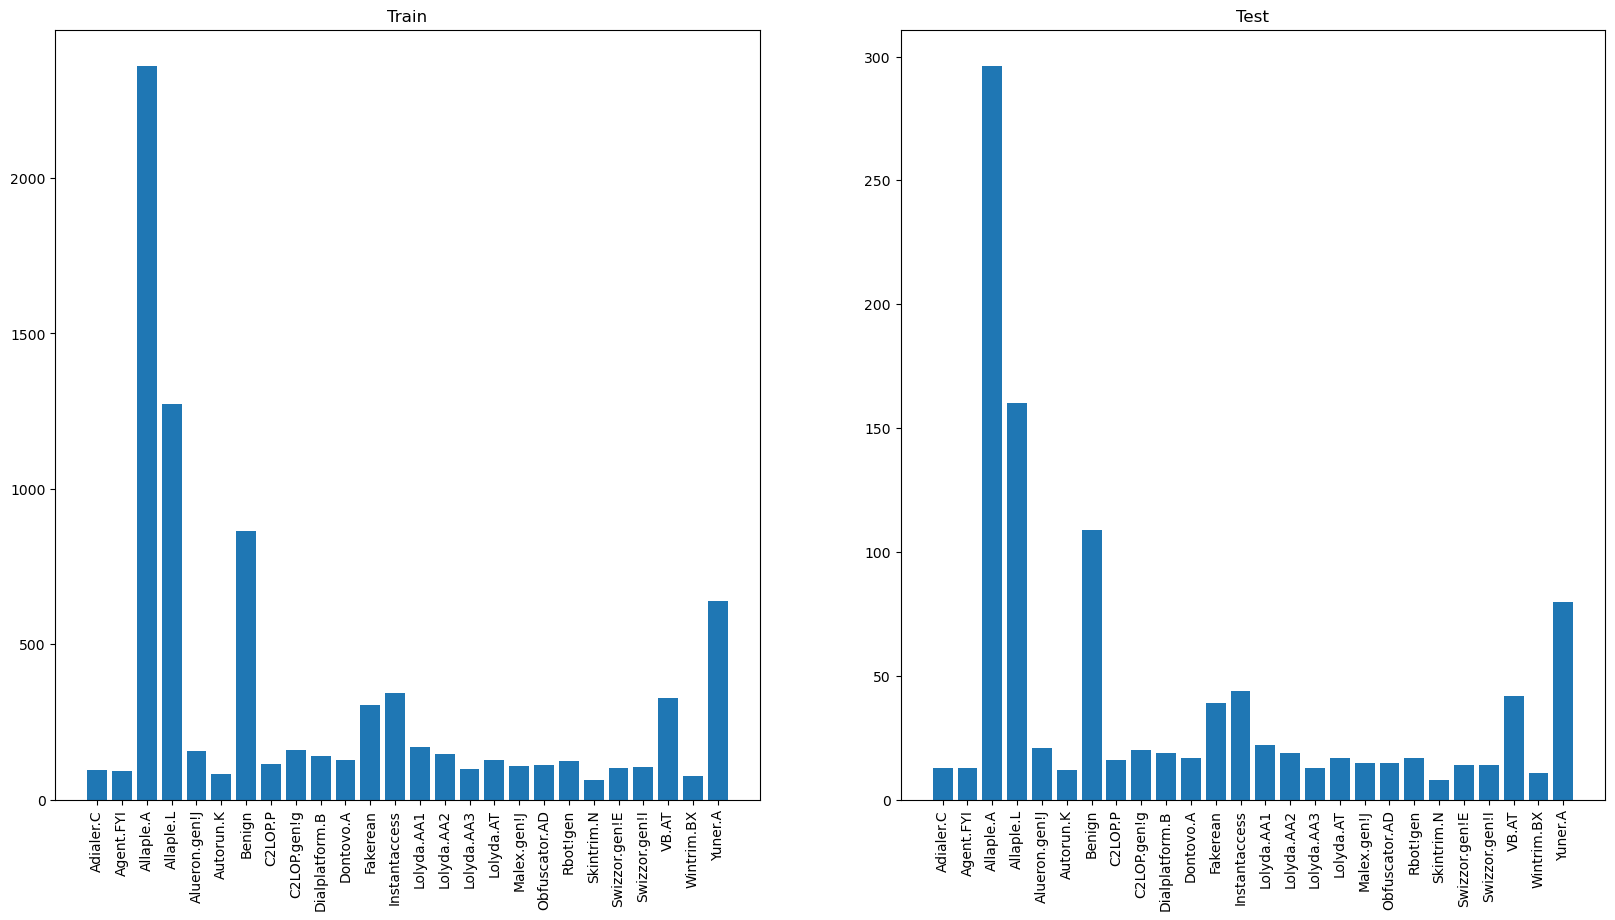

In [13]:
# Display data use combined for benign 
train_occ = train_df.groupby(by="target").size()
test_occ = test_df.groupby(by="target").size()

occur = [train_occ, test_occ]
name = ["Train", "Test"]

plt.figure(figsize=(20, 10))

for i in range(2):
  plt.subplot(1, 2, i+1)
  plt.title(name[i])
  plt.xticks(rotation="vertical")
  plt.bar(class_index.keys(), occur[i])

plt.show()

C:\Users\youssef khaled\AppData\Local\Temp\ipykernel_36772\1961116301.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_labels = train_df.replace({"target": class_index})['target'].to_numpy()


<BarContainer object of 26 artists>

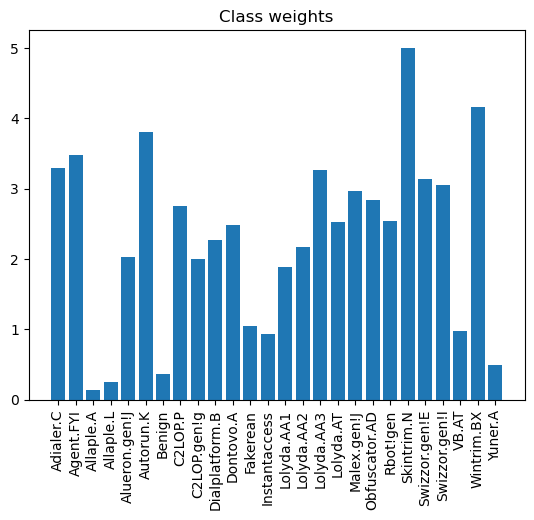

In [14]:
# calculate weights 
from sklearn.utils import class_weight

train_labels = train_df.replace({"target": class_index})['target'].to_numpy()
class_indices = np.array(list(class_index.values()))

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=class_indices, y=train_labels)

class_weights = dict(zip(np.unique(train_labels), class_weights))
class_weights

plt.title("Class weights")
plt.xticks(rotation="vertical")
plt.bar(class_index.keys(), class_weights.values())

In [15]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import AUC, Precision, Recall, Accuracy

In [16]:

num_classes = len(class_index)

def malware_model():
    Malware_model = Sequential()
    Malware_model.add(Conv2D(64, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0],target_size_custom[1],3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//2,target_size_custom[1]//2,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=(target_size_custom[0]//4,target_size_custom[1]//4,3)))

    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Conv2D(16, (3, 3), activation='relu'))
    Malware_model.add(MaxPooling2D(pool_size=(2, 2)))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Flatten())
    Malware_model.add(Dense(128, activation='relu'))
    Malware_model.add(Dropout(0.25))
    Malware_model.add(Dense(50, activation='relu'))
    Malware_model.add(Dropout(0.5))
    Malware_model.add(Dense(num_classes, activation='softmax'))
    Malware_model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"], weighted_metrics=['accuracy'])
    return Malware_model


Malware_model = malware_model()
Malware_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 254, 254, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 32)      

In [17]:
cp_callback = ModelCheckpoint(
    save_checkpoints_path, verbose=1, monitor="val_accuracy")
# Malware_model.load_weights(filepath = save_checkpoints_path, skip_mismatch=False, by_name=False, options=None)

history = Malware_model.fit(train_gen, validation_data=val_gen, epochs=10,  class_weight=class_weights, callbacks = [cp_callback])

Epoch 1/10
521/521 [==============================] - ETA: 0s - loss: 2.4741 - accuracy: 0.2590 - weighted_accuracy: 0.2727
Epoch 1: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 44s 75ms/step - loss: 2.4741 - accuracy: 0.2590 - weighted_accuracy: 0.2727 - val_loss: 1.6094 - val_accuracy: 0.4646 - val_weighted_accuracy: 0.4646
Epoch 2/10
521/521 [==============================] - ETA: 0s - loss: 1.1171 - accuracy: 0.6532 - weighted_accuracy: 0.6478
Epoch 2: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 37s 71ms/step - loss: 1.1171 - accuracy: 0.6532 - weighted_accuracy: 0.6478 - val_loss: 0.4759 - val_accuracy: 0.8661 - val_weighted_accuracy: 0.8661
Epoch 3/10
521/521 [==============================] - ETA: 0s - loss: 0.6308 - accuracy: 0.7943 - weighted_accuracy: 0.7880
Epoch 3: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 36s 70ms/step - loss: 0.6308 - accuracy: 0.7943 - weighted_accuracy: 0.7880 - val_loss: 0.3880 - val_accuracy: 0.8419 - val_weighted_accuracy: 0.8419
Epoch 4/10
521/521 [==============================] - ETA: 0s - loss: 0.4967 - accuracy: 0.8304 - weighted_accuracy: 0.8220
Epoch 4: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 37s 70ms/step - loss: 0.4967 - accuracy: 0.8304 - weighted_accuracy: 0.8220 - val_loss: 0.3240 - val_accuracy: 0.8613 - val_weighted_accuracy: 0.8613
Epoch 5/10
521/521 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.8598 - weighted_accuracy: 0.8489
Epoch 5: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 36s 69ms/step - loss: 0.3950 - accuracy: 0.8598 - weighted_accuracy: 0.8489 - val_loss: 0.3142 - val_accuracy: 0.8652 - val_weighted_accuracy: 0.8652
Epoch 6/10
521/521 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8715 - weighted_accuracy: 0.8577
Epoch 6: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 36s 69ms/step - loss: 0.3627 - accuracy: 0.8715 - weighted_accuracy: 0.8577 - val_loss: 0.1766 - val_accuracy: 0.9515 - val_weighted_accuracy: 0.9515
Epoch 7/10
521/521 [==============================] - ETA: 0s - loss: 0.3325 - accuracy: 0.8915 - weighted_accuracy: 0.8697
Epoch 7: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 37s 70ms/step - loss: 0.3325 - accuracy: 0.8915 - weighted_accuracy: 0.8697 - val_loss: 0.2307 - val_accuracy: 0.8778 - val_weighted_accuracy: 0.8778
Epoch 8/10
521/521 [==============================] - ETA: 0s - loss: 0.2881 - accuracy: 0.8930 - weighted_accuracy: 0.8812
Epoch 8: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 36s 70ms/step - loss: 0.2881 - accuracy: 0.8930 - weighted_accuracy: 0.8812 - val_loss: 0.2153 - val_accuracy: 0.8817 - val_weighted_accuracy: 0.8817
Epoch 9/10
521/521 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.8998 - weighted_accuracy: 0.8862
Epoch 9: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 36s 68ms/step - loss: 0.2753 - accuracy: 0.8998 - weighted_accuracy: 0.8862 - val_loss: 0.1942 - val_accuracy: 0.9428 - val_weighted_accuracy: 0.9428
Epoch 10/10
521/521 [==============================] - ETA: 0s - loss: 0.2614 - accuracy: 0.9029 - weighted_accuracy: 0.8845
Epoch 10: saving model to ..\model_checkpoints


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


INFO:tensorflow:Assets written to: ..\model_checkpoints\assets


521/521 [==============================] - 36s 68ms/step - loss: 0.2614 - accuracy: 0.9029 - weighted_accuracy: 0.8845 - val_loss: 0.2461 - val_accuracy: 0.9408 - val_weighted_accuracy: 0.9408


In [8]:

# Save the trained model
model_save_path = "./saved/malware_model.h5"  # Path to save the model
Malware_model.save(model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to ./saved/malware_model.h5


dict_keys(['loss', 'accuracy', 'weighted_accuracy', 'val_loss', 'val_accuracy', 'val_weighted_accuracy'])


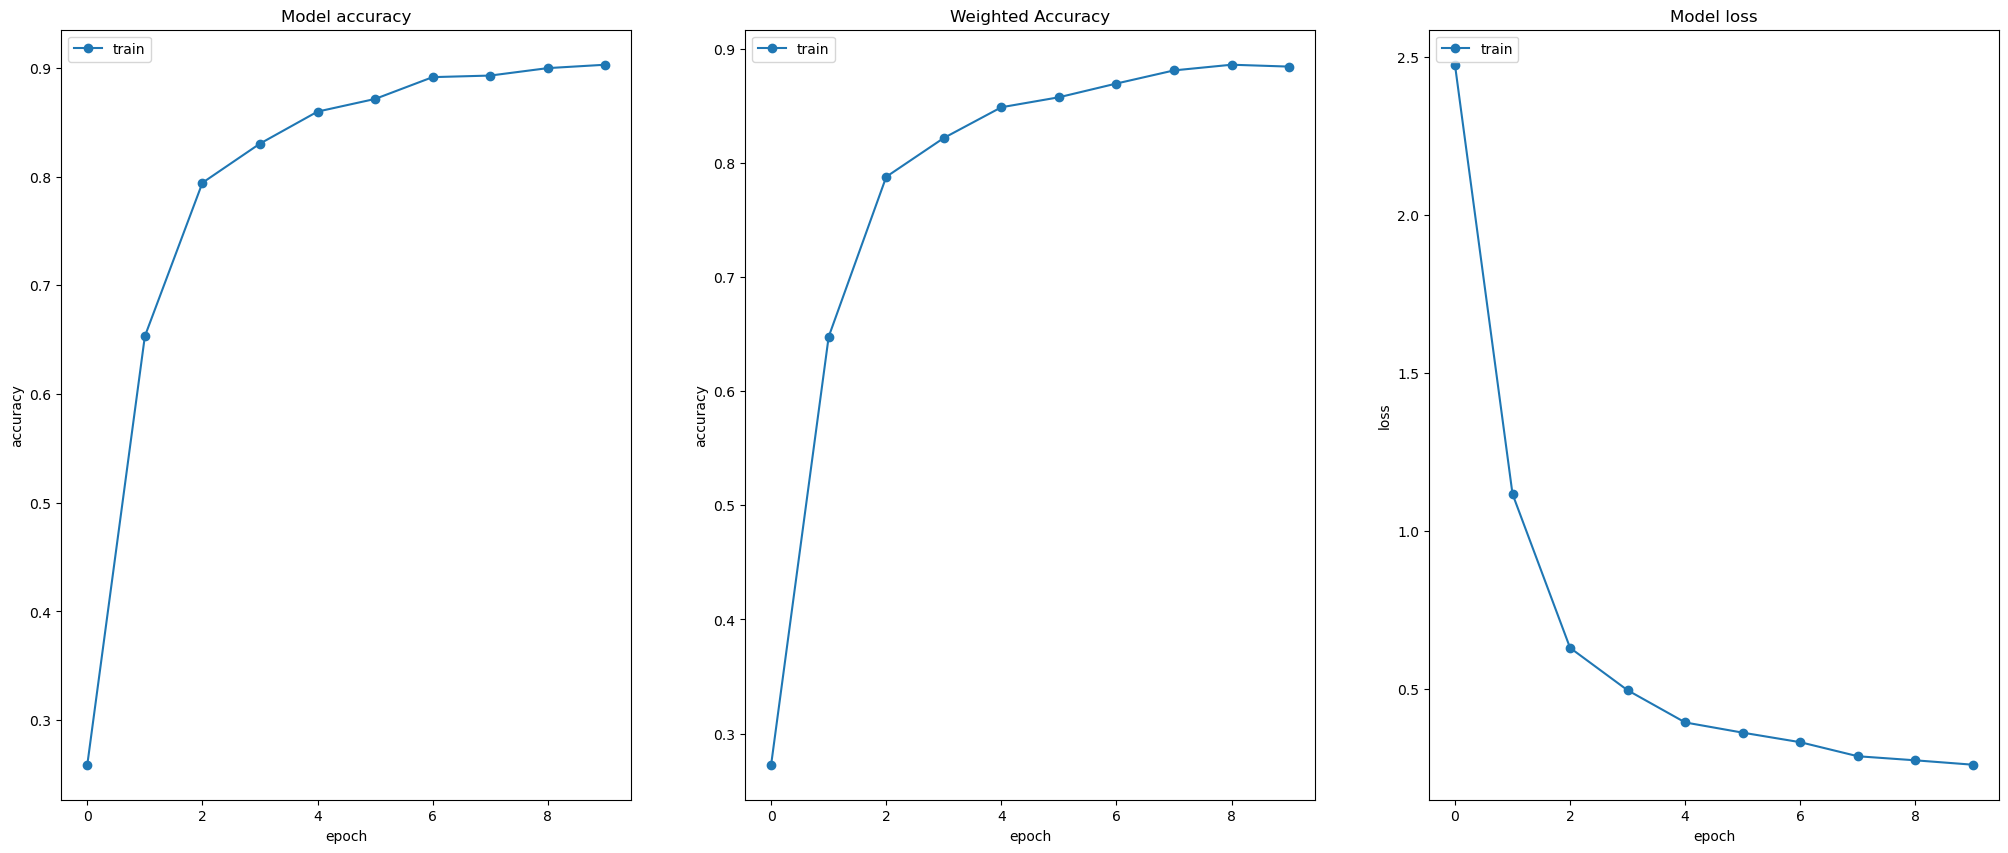

In [18]:
print(history.history.keys())
plt.figure(figsize=(25, 10))
#  "Accuracy"
plt.subplot(1, 3, 1)
plt.plot(history.history['accuracy'], marker='o')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
#  "Weighted Accuracy"
plt.subplot(1, 3, 2)
plt.plot(history.history['weighted_accuracy'], marker='o')
plt.title('Weighted Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
# "Loss"
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], marker='o')
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [19]:
metric_list = Malware_model.evaluate(test_gen, batch_size=batch_size, verbose=1)

print('evaluate_accuracy=%.3f' %metric_list[1])
print('evaluate_weighted_accuracy=%.3f' %metric_list[2])


67/67 [==============================] - 3s 48ms/step - loss: 0.2115 - accuracy: 0.9437 - weighted_accuracy: 0.9437
evaluate_accuracy=0.944
evaluate_weighted_accuracy=0.944


In [20]:
from sklearn import metrics


# Predict
y_pred = Malware_model.predict(test_gen)
y_test_predicted = np.argmax(y_pred, axis=1)

# Get class names
classes = list(train_gen.class_indices.keys())

# Generate classification report
report = metrics.classification_report(
    test_gen.classes,
    y_test_predicted,
    target_names=classes,
    output_dict=True,
    zero_division=0  # avoid warnings for undefined precision/recall
)

# Convert to pandas DataFrame
df_report = pd.DataFrame(report).transpose()

# Round for better readability
df_report = df_report.round(3)


# Print nicely
print(df_report.to_string())

67/67 [==============================] - 2s 35ms/step
                precision  recall  f1-score   support
Adialer.C           1.000   1.000     1.000    13.000
Agent.FYI           1.000   1.000     1.000    13.000
Allaple.A           0.997   0.993     0.995   296.000
Allaple.L           0.994   1.000     0.997   160.000
Alueron.gen!J       1.000   0.952     0.976    21.000
Autorun.K           0.000   0.000     0.000    12.000
Benign              0.977   0.789     0.873   109.000
C2LOP.P             0.786   0.688     0.733    16.000
C2LOP.gen!g         0.625   1.000     0.769    20.000
Dialplatform.B      1.000   1.000     1.000    19.000
Dontovo.A           1.000   1.000     1.000    17.000
Fakerean            0.927   0.974     0.950    39.000
Instantaccess       0.978   1.000     0.989    44.000
Lolyda.AA1          1.000   0.909     0.952    22.000
Lolyda.AA2          0.905   1.000     0.950    19.000
Lolyda.AA3          0.812   1.000     0.897    13.000
Lolyda.AT           1.000   